In [6]:
!pip install jiwer torchmetrics 
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import DataLoader, Dataset
import torchaudio
from glob import glob
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from jiwer import wer, cer
from torch.cuda.amp import autocast
from torchmetrics import Metric
# from pytorch_lightning import LightningModule, Trainer
# from pytorch_lightning.loggers import WandbLogger
# from pytorch_lightning.loggers import TensorBoardLogger
# from pytorch_lightning.callbacks.model_checkpoint import ModelCheckpoint
# from pytorch_lightning.callbacks import LearningRateMonitor
# import wandb
import random
import math
from torch.utils.tensorboard import SummaryWriter
from sklearn.model_selection import train_test_split
import os
import zipfile

# torch.autograd.set_detect_anomaly(False)
# torch.autograd.profiler.profile(False)
# torch.autograd.profiler.emit_nvtx(False)

random.seed(632)
np.random.seed(632)
torch.random.manual_seed(632)

os.chdir('/content/data')

     |████████████████████████████████| 408 kB 8.2 MB/s 
     |████████████████████████████████| 50 kB 7.4 MB/s 
  Created wheel for python-Levenshtein: filename=python_Levenshtein-0.12.2-cp37-cp37m-linux_x86_64.whl size=149866 sha256=5fd96bca02bb604365ad0965381cdd282ef819ed3b01805b7effff6560827463
  Stored in directory: /root/.cache/pip/wheels/05/5f/ca/7c4367734892581bb5ff896f15027a932c551080b2abd3e00d
Successfully built python-Levenshtein


In [7]:
for file in os.listdir():
    zip_ref = zipfile.ZipFile(file, 'r')
    zip_ref.extractall()
    zip_ref.close()

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
TARGET_SR = 16000
WINDOW_SIZE = 0.02
WINDOW_STRIDE = 0.01
N_FFT = int(TARGET_SR * WINDOW_SIZE)
HOP_LENGHT =int(TARGET_SR * WINDOW_STRIDE)
WINDOW_LENGHT = 200
CHAR2IDX = {char:idx for idx, char in enumerate(['_', " ", "а", "ә", "б", "в", "г", "ғ", "д", "е", "ё", "ж", "з",
                                                 "и", "й", "к", "қ", "л", "м", "н", "ң", "о", "ө", "п", "р", "с",
                                                 "т", "у", "ұ", "ү", "ф", "х", "һ", "ц", "ч", "ш", "щ", "ъ", "ы",
                                                 "і", "ь", "э", "ю", "я"])}
IDX2CHAR = {idx:char for char, idx in CHAR2IDX.items()}

In [9]:
df = pd.read_csv('/content/drive/MyDrive/NU_STT/nu_stt.csv')
df.head()

,audio_path,text,duration
0,/content/data/ISSAI_KSC_335RS/Audios/5f1c436e3...,оның басты міндеті қазақстанның жаһандық бәсек...,11.605313
1,/content/data/ISSAI_KSC_335RS/Audios/5f1528b0c...,сырттан аққаншықты бөліп алып өзіне қарай икем...,7.424000
2,/content/data/ISSAI_KSC_335RS/Audios/5f0ec1cdc...,редакция жабдыктары мен гимаратты сақтандыруға...,6.780250
3,/content/data/ISSAI_KSC_335RS/Audios/5f2a55745...,қартайған шығарсыз сіз түсінбей отырмыз біз,5.717313
4,/content/data/ISSAI_KSC_335RS/Audios/5f0168058...,жер сілкінісінің қуаты жеті де төрт балға цуне...,9.301312


In [22]:
class AudioDataset(Dataset):
    def __init__(self, data_frame, transformation, chr2idx, device,
                 sample_rate=16000, audio_augm=None, spec_augm=None):
        self.audio_paths = data_frame.audio_path.to_list()
        self.chr2idx = chr2idx
        self.text = data_frame.text.apply(lambda x: self.text_preprocess(x))
        self.device = device
        self.transformation = transformation
        self.spec_augm = spec_augm
        self.sample_rate=sample_rate
        self.audio_augm = audio_augm
        
        
    def __len__(self):
        return len(self.audio_paths)
    
    
    def __getitem__(self, idx):
        audio_path = self.audio_paths[idx]
        text = self.text[idx]
        signal, sr = torchaudio.load(audio_path)
        spect = self.audio_preprocess(signal, sr)
        spec = self.apply_spec_augm(spect)
        # transcript = self.text_preprocess(text)
        
        return spect, text
    
    
    def audio_preprocess(self, signal, sr):
        if sr != self.sample_rate:
            signal = self.resample(signal, sr)
        
        signal = self.apply_audio_augm(signal)
        signal = self.to_mono(signal)
        spect = self.transformation(signal)
        spect = torch.log1p(spect)
        
        return spect
    
    
    def resample(self, signal, source_sr):
        resampler = torchaudio.transforms.Resample(orig_freq=source_sr, new_freq=self.sample_rate)
        signal = resampler(signal)
        
        return signal
    
    
    def apply_audio_augm(self, signal):
        if self.audio_augm is None:
            return signal
        
        signal = signal.cpu()
        for augm in self.audio_augm:
            signal = augm(signal)
            
        return signal
        
        
    def to_mono(self, signal):
        if signal.shape[0]==0:
            signal = signal.squeeze()
        else:
            signal = signal.mean(axis=0)
            
        return signal
    
    
    def apply_spec_augm(self, spect):
        if self.spec_augm is None:
            return spect
        
        spect = spect.unsqueeze(0)
        for augm in self.spec_augm:
            spect = augm(spect)
                    
        return spect
    
    
    def text_preprocess(self, text):
        transcript = list(filter(None, [self.chr2idx.get(x) for x in list(text)]))
        return transcript

In [23]:
def batch_preprocessing(batch):
    batch = sorted(batch, key=lambda sample: sample[0].size(1), reverse=True)
    longest_sample = batch[0][0]
    freq_size = longest_sample.size(0)
    minibatch_size = len(batch)
    max_seqlength = longest_sample.size(1)
    inputs = torch.zeros(minibatch_size, 1, freq_size, max_seqlength)
    input_percentages = torch.FloatTensor(minibatch_size)
    target_sizes = torch.IntTensor(minibatch_size)
    targets = []
    for x in range(minibatch_size):
        sample = batch[x]
        tensor = sample[0]
        target = sample[1]
        seq_length = tensor.size(1)
        inputs[x][0].narrow(1, 0, seq_length).copy_(tensor)
        input_percentages[x] = seq_length / float(max_seqlength)
        target_sizes[x] = len(target)
        targets.extend(target)
    targets = torch.tensor(targets, dtype=torch.long)
    
    return inputs, targets, input_percentages, target_sizes


class AudioDataLoader(DataLoader):
    def __init__(self, *args, **kwargs):
        super(AudioDataLoader, self).__init__(*args, **kwargs)
        self.collate_fn = batch_preprocessing

In [14]:
spectogram = torchaudio.transforms.Spectrogram(n_fft=N_FFT,
                                              win_length=WINDOW_LENGHT,
                                              hop_length=HOP_LENGHT,
                                               window_fn=torch.hamming_window)

In [25]:
dataset = AudioDataset(df, spectogram, CHAR2IDX, device, TARGET_SR)

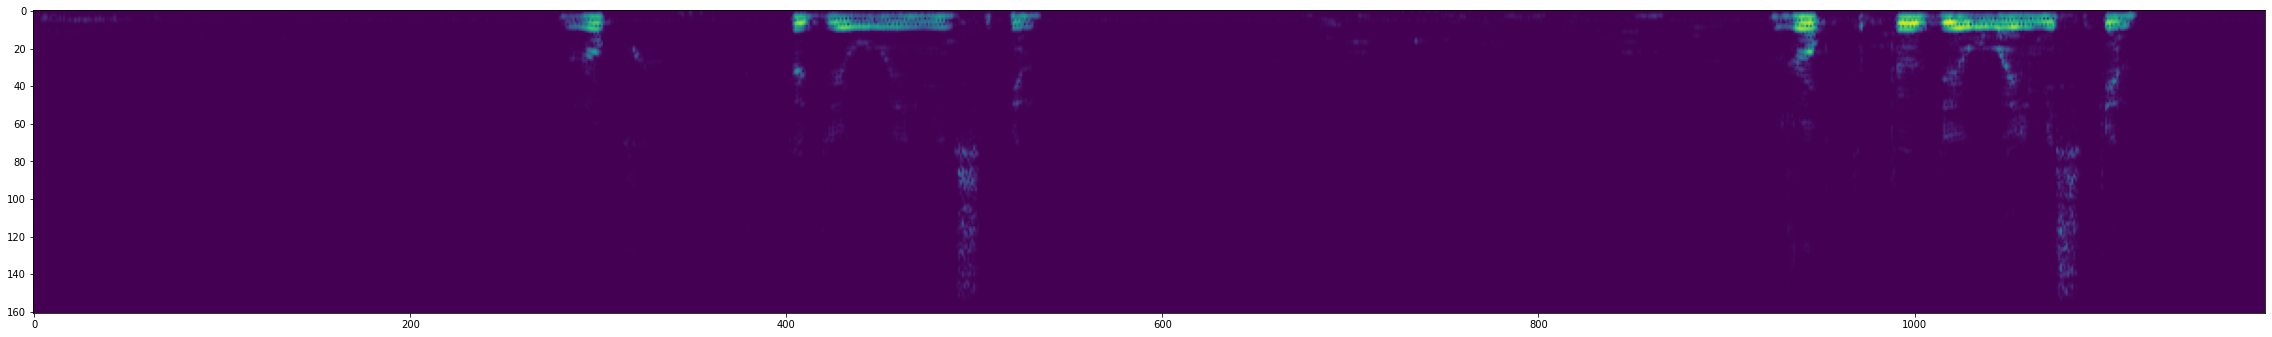

In [26]:
plt.figure(figsize=(40, 20))
plt.imshow(dataset[10][0].cpu())
plt.show()

In [27]:
def greedy_decode(probas, idx2char, blank_idx=0):
    max_values, classes = torch.max(probas, dim=-1)
    texts = []
    for sequence in range(len(classes)):
        sequence_len = len(classes[sequence])
        text = ''
        for i in range(sequence_len):
            char = idx2char[classes[sequence][i].item()]
            if char != idx2char[blank_idx]:
                if i != 0 and char == idx2char[classes[sequence][i-1].item()]:
                    continue
                text += char
        texts.append(text)
        
    return texts

def get_ground_truth(y, target_sizes):
    texts = []
    idx = 0
    for size in target_sizes:
        text = ''
        for i in range(size.item()):
            text += IDX2CHAR[y[idx+i].item()]
            
        texts.append(text)
        idx += size
        
    return texts

In [31]:
class DeepSpeech2(nn.Module):
    def __init__(self, n_feature, n_hidden, n_class, dropout = 0, max_clip_relu = 20, n_rnn_layer=3):
        super(DeepSpeech2, self).__init__()
        self.n_hidden = n_hidden
        self.conv_block = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=(41, 11), stride=(2, 2), padding=(20, 5)),
            nn.BatchNorm2d(32),
            nn.Hardtanh(0, max_clip_relu, inplace=True),
            nn.Conv2d(32, 32, kernel_size=(21, 11), stride=(2, 1), padding=(10, 5)),
            nn.BatchNorm2d(32),
            nn.Hardtanh(0, max_clip_relu, inplace=True)
        )
        
        rnn_input_size = n_feature
        rnn_input_size = int(math.floor(rnn_input_size + 2 * 20 - 41) / 2 + 1)
        rnn_input_size = int(math.floor(rnn_input_size + 2 * 10 - 21) / 2 + 1)
        rnn_input_size *= 32
        self.bi_rnn = nn.GRU(rnn_input_size, n_hidden, bidirectional=True, num_layers=n_rnn_layer)
        self.out = nn.Sequential(nn.Linear(in_features=n_hidden, out_features=44, bias=False))
    

    def forward(self, x, input_sizes=None):
        output_sizes = None
        if input_sizes:
          output_sizes = self.get_output_lenght(input_sizes)
        x = self.conv_block(x)
        x = x.view(x.size(0), x.size(1) * x.size(2), x.size(3))
        x = x.permute(2, 0, 1)
        x, _ = self.bi_rnn(x)
        x = x[:, :, :self.n_hidden] + x[:, :, self.n_hidden:]
        t, n, h = x.size(0), x.size(1), x.size(2)
        x = x.view(t*n, -1)
        x = self.out(x)
        x = x.view(t, n, -1)
        
        return x, output_sizes
    

    def get_output_lenght(self, input_lenght):
        seq_len = input_lenght
        for block in self.conv_block.modules():
            if type(block) == nn.modules.conv.Conv2d:
                seq_len = ((seq_len + 2 * block.padding[1] - block.dilation[1] * (block.kernel_size[1] - 1) - 1) // block.stride[1] + 1)
        return seq_len.int()

In [33]:
loader = AudioDataLoader(dataset, batch_size=1, shuffle=True)
model = DeepSpeech2(161, 2048, len(IDX2CHAR), dropout=0.2)
model.load_state_dict(torch.load('/content/drive/MyDrive/NU_STT/models/DeepSpeech2_old/model_deepspeech2_15.pth').state_dict())
model.to(device)
model

DeepSpeech2(
  (conv_block): Sequential(
    (0): Conv2d(1, 32, kernel_size=(41, 11), stride=(2, 2), padding=(20, 5))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Hardtanh(min_val=0, max_val=20, inplace=True)
    (3): Conv2d(32, 32, kernel_size=(21, 11), stride=(2, 1), padding=(10, 5))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): Hardtanh(min_val=0, max_val=20, inplace=True)
  )
  (bi_rnn): GRU(1312, 2048, num_layers=3, bidirectional=True)
  (out): Sequential(
    (0): Linear(in_features=2048, out_features=44, bias=False)
  )
)

In [42]:
def predict(audio_file, model):
    spectogram = torchaudio.transforms.Spectrogram(n_fft=N_FFT,
                                              win_length=WINDOW_LENGHT,
                                              hop_length=HOP_LENGHT,
                                               window_fn=torch.hamming_window)
    signal, sr = torchaudio.load(audio_file)
    if sr != 16000:
        resampler = torchaudio.transforms.Resample(orig_freq=sr, new_freq=16000)
        signal = resampler(signal, 16000)

    spect = spectogram(signal)
    spect = torch.log1p(spect).unsqueeze(0)
    print(spect.shape)
    spect = spect.to(device)
    preds, _ = model(spect)
    probs = nn.functional.softmax(preds, dim=-1).cpu().detach()
    decoded = greedy_decode(probs.transpose(0, 1), IDX2CHAR)

    return decoded

In [45]:
predict(df.audio_path[15], model)

torch.Size([1, 1, 161, 1707])


['жетінші ақпан күні сағат тыс алты он сегіз мөнөлде ақынның сексенүш жылдығына орай алматыдағы жазушылар одағында қарлығашымн келдің бе атты жаз ақындардың жыр кеше өткізілді']

In [47]:
df.text[15]

'жетінші ақпан күні сағат алты он сегіз нөл нөлде ақынның сексен үш жылдығына орай алматыдағы жазушылар одағында қарлығашым келдің бе атты жас ақындардың жыр кеші өткізілді'